<a href="https://colab.research.google.com/github/GeoKauko/TheNavySeals/blob/main/3_Postprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Postprocessing

In [1]:
# Set up working directory and project directories

# Define function to check if the code is run in Google Colab
def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

import os

# Set working directory to Google Drive or Local based on usage
if in_colab():
    ## GOOGLE COLAB USERS ONLY
    ## Mount Google Drive for data retrieval
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')

    project_path = '/content/drive/MyDrive/TheNavySeals/'

    !pip install torch rasterio torchvision tifffile segmentation-models-pytorch -q
else:
    ## LOCAL USERS ONLY
    ## Change the path to your project directory
    print("Running Locally")
    os.chdir('D:\E_2024_P6\SEAL')
    project_path = ''

## Import packages
import os
import rasterio
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from osgeo import gdal

## Define paths
source_image = os.path.join(project_path, 'data/22MAR25134903-P3DS-014983717010_01_P001.TIF')
source_model = os.path.join(project_path, 'data/2_deep_learning/Model_Test')

reduced_image_path = os.path.join(project_path, 'data/3_postprocessing/3a_reduced_image')
os.makedirs(reduced_image_path, exist_ok=True)
reduced_image = os.path.join(reduced_image_path, '3a_reduced_image.tif')

tiled_images_path = os.path.join(project_path, 'data/3_postprocessing/3b_tiled_images')
os.makedirs(tiled_images_path, exist_ok=True)

predicted_masks_path = os.path.join(project_path, 'data/3_postprocessing/3c_predicted_masks')
os.makedirs(predicted_masks_path, exist_ok=True)

predicted_masks_georef_path = os.path.join(project_path, 'data/3_postprocessing/3d_predicted_masks_georef')
os.makedirs(predicted_masks_path, exist_ok=True)

predicted_mask_path = os.path.join(project_path, 'data/3_postprocessing/3e_predicted_mask_final')
os.makedirs(predicted_mask_path, exist_ok=True)
predicted_mask = os.path.join(predicted_mask_path, '3e_predicted_mask.tif')

mask_heatmap_path = os.path.join(project_path, 'data/3_postprocessing/3f_mask_heatmap')
os.makedirs(mask_heatmap_path, exist_ok=True)
mask_heatmap = os.path.join(mask_heatmap_path, '3f_mask_heatmap.tif')

Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Process the image

# Reduce image for increased processing speed
def reduce_radiometric_resolution(input_path, output_path, input_res=11):
    '''
    Reduce the radiometric resolution of the input raster and save the output raster.

    Args:
    - input_path (string): Path to the input raster.
    - output_path (string): Path to the output raster.
    - input_res (int): Radiometric resolution of the input raster in bits.
    '''
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with rasterio.open(input_path) as src:
        # Read the number of bands
        num_bands = src.count

        # Initialize an array to store the scaled bands
        scaled_arrays = []

        for band in range(1, num_bands + 1):
            # Read the image band as a numpy array
            image_array = src.read(band, masked=True)

            # Rescale the pixel values to fit within 8-bit range (0-255)
            scaled_array = (image_array / (2**input_res - 1) * 255).astype(np.uint8)

            # Append the scaled array to the list
            scaled_arrays.append(scaled_array)

        # Stack the scaled arrays along the first axis to create a 3D array
        scaled_arrays = np.stack(scaled_arrays, axis=0)

        # Create a new raster profile with 8-bit pixel depth
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=num_bands)

        # Write the scaled arrays to a new raster file
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(scaled_arrays)

reduce_radiometric_resolution(source_image, reduced_image)

# Tile the image into 224x224 px tiles
def split_and_save_raster(input_raster_path, part_width, part_height, output_folder):
    '''
    Split a raster into multiple tiles of length part_width and height part_height, and save them in output_folder.

    Args:
    - input_raster_path: path to the input raster.
    - part_width (int): Width of each tile.
    - part_height (int): Height of each tile.
    - output_folder (str): Directory to save the rasters.
    '''
    # Open the raster
    dataset = gdal.Open(input_raster_path)

    # Get raster dimensions
    width = dataset.RasterXSize
    height = dataset.RasterYSize

    # Calculate the number of parts
    num_parts_x = width // part_width
    num_parts_y = height // part_height

    # Get the number of bands
    bands = dataset.RasterCount

    # Split the raster and save
    for i in range(num_parts_x):
        for j in range(num_parts_y):
            x_offset = i * part_width
            y_offset = j * part_height

            # Read the split region
            part = dataset.ReadAsArray(x_offset, y_offset, part_width, part_height)

            # Expand dimensions if there's only one band
            if bands == 1:
               part = np.expand_dims(part, axis=0)

            # Create a new GDAL dataset to save the split part
            driver = gdal.GetDriverByName('GTiff')
            output_path = os.path.join(output_folder, f'part_{i}_{j}.tif')
            out_dataset = driver.Create(output_path, part_width, part_height, bands, gdal.GDT_UInt16)

            # Write data to the new dataset
            for band in range(bands):
                out_band = out_dataset.GetRasterBand(band + 1)
                out_band.WriteArray(part[band])

            # Set georeference and projection
            geo_transform = list(dataset.GetGeoTransform())
            geo_transform[0] += x_offset * geo_transform[1]
            geo_transform[3] += y_offset * geo_transform[5]
            out_dataset.SetGeoTransform(tuple(geo_transform))
            out_dataset.SetProjection(dataset.GetProjection())

            # Save and close
            out_dataset.FlushCache()
            del out_dataset

    # Close the original dataset
    del dataset

split_and_save_raster(reduced_image, 224, 224, tiled_images_path)

In [2]:
def is_multiband_pil(image_path):
    """
    Check if an image is multiband or singleband using Pillow.

    Args:
        image_path (str): Path to the image file.

    Returns:
        bool: True if the image is multiband (color), False if it is singleband (grayscale).
    """
    try:
        with Image.open(image_path) as img:
            return img.mode in ("RGB", "RGBA", "CMYK", "YCbCr")
    except Exception as e:
        print(f"Error opening image: {e}")
        return False

## Integrate model

In [3]:
from torchvision.transforms import v2 as transforms
import random

torch.manual_seed(0)
batch_size = 8 #Can be changed later

def trans(image):
    image = torchvision.transforms.functional.to_tensor(image)
    image = image.float() / 255.0 #get pixel values between 0 and 1 for uint8
    print(image)

    if image.shape[0] != 1:
        image = image[:3, :, :] #Assumes that first three channels are RGB
        image = torchvision.transforms.functional.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        image = torchvision.transforms.functional.normalize(image, mean=0.445, std=0.269)
    return image

def denormalize(image_tensor): #This is for denormalization for visualisation purposes
    if image_tensor.shape[0] != 1:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image_tensor.device)
    else:
        mean = torch.tensor([0.445]).view(1, 1, 1).to(image_tensor.device)
        std = torch.tensor([0.269]).view(1, 1, 1).to(image_tensor.device)
    image_tensor = image_tensor * std + mean
    return image_tensor

def segmentation_dataset(data_path, transform=None):
   image_files = os.listdir(data_path)
   #random.shuffle(image_files) #TODO: remove line
   image_files = image_files[:] #TODO: remove line. Only loads few patches for now
   dataset = []

   for img_name in image_files:
         image = tifffile.imread(os.path.join(data_path, img_name)) #read .tif file

         if transform:
           image = trans(image)

         dataset.append((image, img_name)) #append the image-mask pair in the dataset

   return dataset

dataset = segmentation_dataset(tiled_images_path, transform=trans)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

tensor([[[0.0706, 0.0667, 0.0706,  ..., 0.0706, 0.0745, 0.0667],
         [0.0745, 0.0667, 0.0667,  ..., 0.0706, 0.0706, 0.0745],
         [0.0667, 0.0667, 0.0706,  ..., 0.0667, 0.0627, 0.0667],
         ...,
         [0.1098, 0.0980, 0.0824,  ..., 0.0706, 0.0706, 0.0667],
         [0.1098, 0.1059, 0.0902,  ..., 0.0745, 0.0667, 0.0706],
         [0.1020, 0.0824, 0.1176,  ..., 0.0745, 0.0745, 0.0706]]])


In [4]:
# Import model (the file path will be changed later)
model = torch.load(source_model)

In [5]:
# transfer model to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

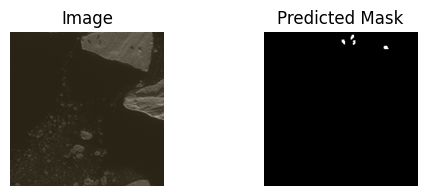

In [6]:
# Predict and save tiff file

pred_masks = []
for i in range(len(dataset)):
#for i in range(30, 35):
  image, img_name = dataset[i]
  image = image.to(device, dtype=torch.float).unsqueeze(0)  # Add batch dimension

  model.eval()
  with torch.no_grad():
    pred = model(image)

  pred = torch.sigmoid(pred).squeeze().cpu().numpy()  # Convert prediction to numpy array
  pred_print = (pred >= 0.5).astype(np.float32)

  pred_masks.append(pred_print)

  save_path = os.path.join(predicted_masks_path, img_name)
  tifffile.imwrite(save_path, pred_print)

  #tifffile.imwrite() # maybe change path

  fig, axes = plt.subplots(1, 2, figsize=(6, 2))

  image_np = denormalize(image.squeeze()).cpu().numpy()
  axes[0].imshow(image_np.transpose(1, 2, 0), cmap = 'gray')  # Use grayscale if single channel
  axes[0].set_title('Image')
  axes[0].axis('off')

  #print(f'Predicted mask shape for imshow: {pred_print.shape}')
  axes[1].imshow(pred_print, cmap = 'gray')  # Use grayscale colormap for binary mask
  axes[1].set_title('Predicted Mask')
  axes[1].axis('off')

plt.show()

In [7]:
def georeference_masks(predicted_masks_path, tiled_images_path, output_path):
    """
    Georeferences mask images in predicted_masks_path to match corresponding images
    in tiled_images_path and saves them in output_path.
    Args:
    - predicted_masks_path (str): Path to directory containing mask images in TIFF format.
    - tiled_images_path (str): Path to directory containing georeferenced images in TIFF format.
    - output_path (str): Path to directory where georeferenced mask images will be saved.
    Returns:
    - None
    """
    # Ensure the output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Function to georeference the mask image
    def georeference_mask(mask_path, image_path, output_path):
        with rasterio.open(image_path) as src:
            # Read metadata from the georeferenced image
            metadata = src.meta.copy()

        with rasterio.open(mask_path) as mask:
            mask_data = mask.read(1)

            # Update metadata for the mask
            metadata.update({
                'count': 1,
                'dtype': 'uint8',
                'nodata': 0
            })

            output_file = os.path.join(output_path, os.path.basename(mask_path))

            with rasterio.open(output_file, 'w', **metadata) as dst:
                dst.write(mask_data, 1)

    # Loop over all mask files and georeference them
    for mask_file in os.listdir(predicted_masks_path):
        if mask_file.endswith('.tif'):
            mask_path = os.path.join(predicted_masks_path, mask_file)
            image_path = os.path.join(tiled_images_path, mask_file)

            if os.path.exists(image_path):
                georeference_mask(mask_path, image_path, output_path)
            else:
                print(f"Warning: Corresponding image for {mask_file} not found.")

    print("Georeferencing completed.")

georeference_masks(predicted_masks_path, tiled_images_path, predicted_masks_georef_path)


Georeferencing completed.


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [8]:
def mosaic_rasters(input_folder, output_path):
    # List to hold the file paths of the rasters to be merged
    input_files = []

    # Loop through the folder and add all .tif files to the list
    for file_name in os.listdir(input_folder):
        print(file_name)
        if file_name.endswith('.tif'):
            input_files.append(os.path.join(input_folder, file_name))

    # Check if we have any input files
    if not input_files:
        raise FileNotFoundError("No .tif files found in the specified folder.")

    # Open the input files
    src_files_to_mosaic = []
    for file in input_files:
        src = gdal.Open(file)
        if src:
            src_files_to_mosaic.append(src)
        else:
            print(f"Failed to open {file}")

    # Create a virtual raster from the input files
    vrt = gdal.BuildVRT('temporary.vrt', src_files_to_mosaic)
    if vrt is None:
        raise ValueError("Failed to create virtual raster (VRT).")

    # Write the virtual raster to a new file
    gdal.Translate(output_path, vrt)

    # Cleanup
    vrt = None
    for src in src_files_to_mosaic:
        src = None

    print(f"Mosaic raster saved as {output_path}")

# Mosaic the masks back together
mosaic_rasters(predicted_masks_path, predicted_mask_path)

# Create a heatmap
def create_heatmap(input_path, output_path):
    """
    Save a heatmap from the given data to a file.

    Args:
        input_path (str): Path to the mask raster.
        output_path (str): Path to save the heatmap image.
    """
    with rasterio.open(input_path) as src:
        input_data = src.read(1)
    plt.figure(figsize=(10, 8))
    plt.imshow(input_data, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title('Heatmap of mask.tif')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

create_heatmap(predicted_mask_path, mask_heatmap)

part_5_125.tif


ValueError: Failed to create virtual raster (VRT).